In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import RELACS as rel
import deeptools.countReadsPerBin as crpb
import glob
import os
sns.set_style("white")
sns.set_context("paper")
%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### NORMALIZATION 

1. get coverage in bin mode
2. identify highly covered bins
3. apply RLE to get normalizing scaling factors

In [162]:
def getCoverage(BamPathsList, bs=8000, p=20, e=True, sample_names=None):
    
    cr = crpb.CountReadsPerBin(BamPathsList, 
                               binLength=bs,
                               stepSize = bs,
                               numberOfProcessors=p, 
                               extendReads=e)
    coverage = cr.run()
    
    if sample_names == None:
        sample_names = [os.path.basename(bam) for bam in BamPathsList]
    
    coverage_df = pd.DataFrame(coverage, columns=sample_names)
    
    return coverage_df


def getRLEFactors(coverage_df, broad=False, plot=True):
    
    idx_dict = dict()
    
    if plot == True:
        plt.figure()
    
    for sample in list(coverage_df):
        
        sorted_df = coverage_df[sample].sort_values(ascending=True)
        cumsum_df = sorted_df.cumsum()
        prop_df = cumsum_df.divide(sorted_df.sum())

        X = (np.array(range(prop_df.shape[0]+1))[1:]) / prop_df.shape[0]
        delta = np.fabs(prop_df.subtract(X, axis=0))
        elbow_X = delta.idxmax()
        elbow_Y = prop_df.loc[elbow_X].max()
        
        if broad == False:
            selected_idx = prop_df.loc[prop_df > elbow_Y].index
        else:
            selected_idx = prop_df.loc[prop_df > 0].index
        
        idx_dict[sample] = set(selected_idx)
        
        if plot == True:
            plt.plot(X,prop_df)
            plt.plot(X,delta)
            plt.axhline(elbow_Y)
            plt.axvline(X[np.fabs(prop_df.subtract(X, axis=0)).values.argmax()])
    
    common_loci = set.intersection(*[idx_dict[sample] for sample in idx_dict])
    
    enrich_df = coverage_df.loc[common_loci]   

    return 1/rel.RLE(enrich_df)[0] 

In [153]:
SNAKEPIPE_OUTDIR="/data/manke/group/ferrari/PhD_project/reference_datasets/autoRELACS_dataset/output_snakePipes_Drosophila_merged"
BamPathsList_H3K4me3 = glob.glob(os.path.join(SNAKEPIPE_OUTDIR,"filtered_bam/*H3K4me3*.bam"))
c_H3K4me3 = getCoverage(BamPathsList_H3K4me3)

Biomek_H3K4me3.filtered.bam    0.010824
manual_H3K4me3.filtered.bam    0.009239
dtype: float64

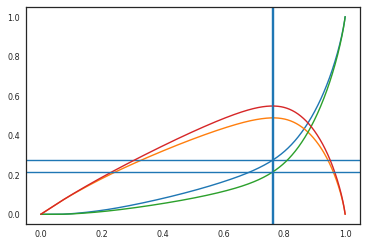

In [165]:
getRLEFactors(c_H3K4me3)/100

In [155]:
SNAKEPIPE_OUTDIR="/data/manke/group/ferrari/PhD_project/reference_datasets/autoRELACS_dataset/output_snakePipes_Drosophila_merged"
BamPathsList_H3K27ac = glob.glob(os.path.join(SNAKEPIPE_OUTDIR,"filtered_bam/*H3K27ac*.bam"))
c_H3K27ac = getCoverage(BamPathsList_H3K27ac)

manual_H3K27ac.filtered.bam    0.006933
Biomek_H3K27ac.filtered.bam    0.014424
dtype: float64

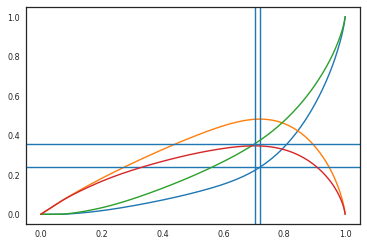

In [166]:
getRLEFactors(c_H3K27ac)/100

In [157]:
SNAKEPIPE_OUTDIR="/data/manke/group/ferrari/PhD_project/reference_datasets/autoRELACS_dataset/output_snakePipes_Drosophila_merged"
BamPathsList_H3K27me3 = glob.glob(os.path.join(SNAKEPIPE_OUTDIR,"filtered_bam/*H3K27me3*.bam"))
c_H3K27me3 = getCoverage(BamPathsList_H3K27me3)

manual_H3K27me3.filtered.bam    0.009741
Biomek_H3K27me3.filtered.bam    0.010266
dtype: float64

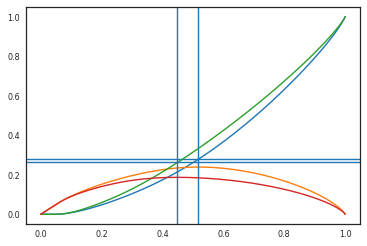

In [167]:
getRLEFactors(c_H3K27me3, broad=True)/100

### CREATE RLE SCALED COVERAGE TRACKS AND PLOT METAPROFILE ON THE MERGED PEAK SET FOR EACH MARK

# H3K4me3

In [134]:
%%bash

module load deeptools

SNAKEPIPE_OUTDIR="/data/manke/group/ferrari/PhD_project/reference_datasets/autoRELACS_dataset/output_snakePipes_Drosophila_merged"

bamCoverage -b $SNAKEPIPE_OUTDIR/filtered_bam/Biomek_H3K4me3.filtered.bam \
-o ../intermediate_files/Biomek_H3K4me3.filtered.RLEscaled.bw \
--scaleFactor 0.010824 -p 20 -e 

bamCoverage -b $SNAKEPIPE_OUTDIR/filtered_bam/manual_H3K4me3.filtered.bam \
-o ../intermediate_files/manual_H3K4me3.filtered.RLEscaled.bw \
--scaleFactor 0.009239 -p 20 -e 

bamFilesList: ['/data/manke/group/ferrari/PhD_project/reference_datasets/autoRELACS_dataset/output_snakePipes_Drosophila_merged/filtered_bam/Biomek_H3K4me3.filtered.bam']
binLength: 50
numberOfSamples: None
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
defaultFragmentLength: 233
numberOfProcessors: 20
verbose: False
region: None
bedFile: None
minMappingQuality: None
ignoreDuplicates: False
chrsToSkip: []
stepSize: 50
center_read: False
samFlag_include: None
samFlag_exclude: None
minFragmentLength: 0
maxFragmentLength: 0
zerosToNans: False
smoothLength: None
save_data: False
out_file_for_raw_data: None
maxPairedFragmentLength: 932
bamFilesList: ['/data/manke/group/ferrari/PhD_project/reference_datasets/autoRELACS_dataset/output_snakePipes_Drosophila_merged/filtered_bam/manual_H3K4me3.filtered.bam']
binLength: 50
numberOfSamples: None
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
defaultFragmentLength: 235
numberOfProcessors: 20
verbose: False
re

In [135]:
%%bash

module load deeptools

computeMatrix reference-point -R ../intermediate_files/Merged_Peaks_H3K4me3.bed \
-S ../intermediate_files/Biomek_H3K4me3.filtered.RLEscaled.bw \
../intermediate_files/manual_H3K4me3.filtered.RLEscaled.bw \
-o ../intermediate_files/H3K4me3_merged_plotProfile.mat.gz \
--referencePoint center --missingDataAsZero -p 20 -b 2000 -a 2000

In [136]:
%%bash

module load deeptools

plotProfile -m ../intermediate_files/H3K4me3_merged_plotProfile.mat.gz \
-o ../figures/H3K4me3_merged_plotProfile.pdf --perGroup --averageType median \
--plotHeight 7 --plotWidth 8 --colors darkred coral

# H3K27ac

In [137]:
%%bash

module load deeptools

SNAKEPIPE_OUTDIR="/data/manke/group/ferrari/PhD_project/reference_datasets/autoRELACS_dataset/output_snakePipes_Drosophila_merged"

bamCoverage -b $SNAKEPIPE_OUTDIR/filtered_bam/Biomek_H3K27ac.filtered.bam \
-o ../intermediate_files/Biomek_H3K27ac.filtered.RLEscaled.bw \
--scaleFactor 0.014424 -p 20 -e 

bamCoverage -b $SNAKEPIPE_OUTDIR/filtered_bam/manual_H3K27ac.filtered.bam \
-o ../intermediate_files/manual_H3K27ac.filtered.RLEscaled.bw \
--scaleFactor 0.006933 -p 20 -e 

bamFilesList: ['/data/manke/group/ferrari/PhD_project/reference_datasets/autoRELACS_dataset/output_snakePipes_Drosophila_merged/filtered_bam/Biomek_H3K27ac.filtered.bam']
binLength: 50
numberOfSamples: None
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
defaultFragmentLength: 213
numberOfProcessors: 20
verbose: False
region: None
bedFile: None
minMappingQuality: None
ignoreDuplicates: False
chrsToSkip: []
stepSize: 50
center_read: False
samFlag_include: None
samFlag_exclude: None
minFragmentLength: 0
maxFragmentLength: 0
zerosToNans: False
smoothLength: None
save_data: False
out_file_for_raw_data: None
maxPairedFragmentLength: 852
bamFilesList: ['/data/manke/group/ferrari/PhD_project/reference_datasets/autoRELACS_dataset/output_snakePipes_Drosophila_merged/filtered_bam/manual_H3K27ac.filtered.bam']
binLength: 50
numberOfSamples: None
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
defaultFragmentLength: 239
numberOfProcessors: 20
verbose: False
re

In [138]:
%%bash

module load deeptools

computeMatrix reference-point -R ../intermediate_files/Merged_Peaks_H3K27ac.bed \
-S ../intermediate_files/Biomek_H3K27ac.filtered.RLEscaled.bw \
../intermediate_files/manual_H3K27ac.filtered.RLEscaled.bw \
-o ../intermediate_files/H3K27ac_merged_plotProfile.mat.gz \
--referencePoint center --missingDataAsZero -p 20 -b 2000 -a 2000

In [139]:
%%bash

module load deeptools

plotProfile -m ../intermediate_files/H3K27ac_merged_plotProfile.mat.gz \
-o ../figures/H3K27ac_merged_plotProfile.pdf --perGroup --averageType median \
--plotHeight 7 --plotWidth 8 --colors darkgreen limegreen

# H3K27me3

In [159]:
%%bash

module load deeptools

SNAKEPIPE_OUTDIR="/data/manke/group/ferrari/PhD_project/reference_datasets/autoRELACS_dataset/output_snakePipes_Drosophila_merged"

bamCoverage -b $SNAKEPIPE_OUTDIR/filtered_bam/Biomek_H3K27me3.filtered.bam \
-o ../intermediate_files/Biomek_H3K27me3.filtered.RLEscaled.bw \
--scaleFactor 0.010266 -p 20 -e 

bamCoverage -b $SNAKEPIPE_OUTDIR/filtered_bam/manual_H3K27me3.filtered.bam \
-o ../intermediate_files/manual_H3K27me3.filtered.RLEscaled.bw \
--scaleFactor 0.009741 -p 20 -e 

bamFilesList: ['/data/manke/group/ferrari/PhD_project/reference_datasets/autoRELACS_dataset/output_snakePipes_Drosophila_merged/filtered_bam/Biomek_H3K27me3.filtered.bam']
binLength: 50
numberOfSamples: None
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
defaultFragmentLength: 253
numberOfProcessors: 20
verbose: False
region: None
bedFile: None
minMappingQuality: None
ignoreDuplicates: False
chrsToSkip: []
stepSize: 50
center_read: False
samFlag_include: None
samFlag_exclude: None
minFragmentLength: 0
maxFragmentLength: 0
zerosToNans: False
smoothLength: None
save_data: False
out_file_for_raw_data: None
maxPairedFragmentLength: 1012
bamFilesList: ['/data/manke/group/ferrari/PhD_project/reference_datasets/autoRELACS_dataset/output_snakePipes_Drosophila_merged/filtered_bam/manual_H3K27me3.filtered.bam']
binLength: 50
numberOfSamples: None
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
defaultFragmentLength: 245
numberOfProcessors: 20
verbose: False

In [160]:
%%bash

module load deeptools

computeMatrix scale-regions -R ../intermediate_files/Merged_Peaks_H3K27me3.bed \
-S ../intermediate_files/Biomek_H3K27me3.filtered.RLEscaled.bw \
../intermediate_files/manual_H3K27me3.filtered.RLEscaled.bw \
-o ../intermediate_files/H3K27me3_merged_plotProfile.mat.gz \
--missingDataAsZero -p 20 -b 400 -a 400

In [161]:
%%bash

module load deeptools

plotProfile -m ../intermediate_files/H3K27me3_merged_plotProfile.mat.gz \
-o ../figures/H3K27me3_merged_plotProfile.pdf --perGroup --averageType median \
--plotHeight 7 --plotWidth 8 --colors black dimgray